In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [2]:
df=pd.read_csv("df_EDA.csv")

In [3]:
df.drop(["Month_Str","DayOfWeek_Str","Quarter","Unnamed: 0"],axis=1,inplace=True)

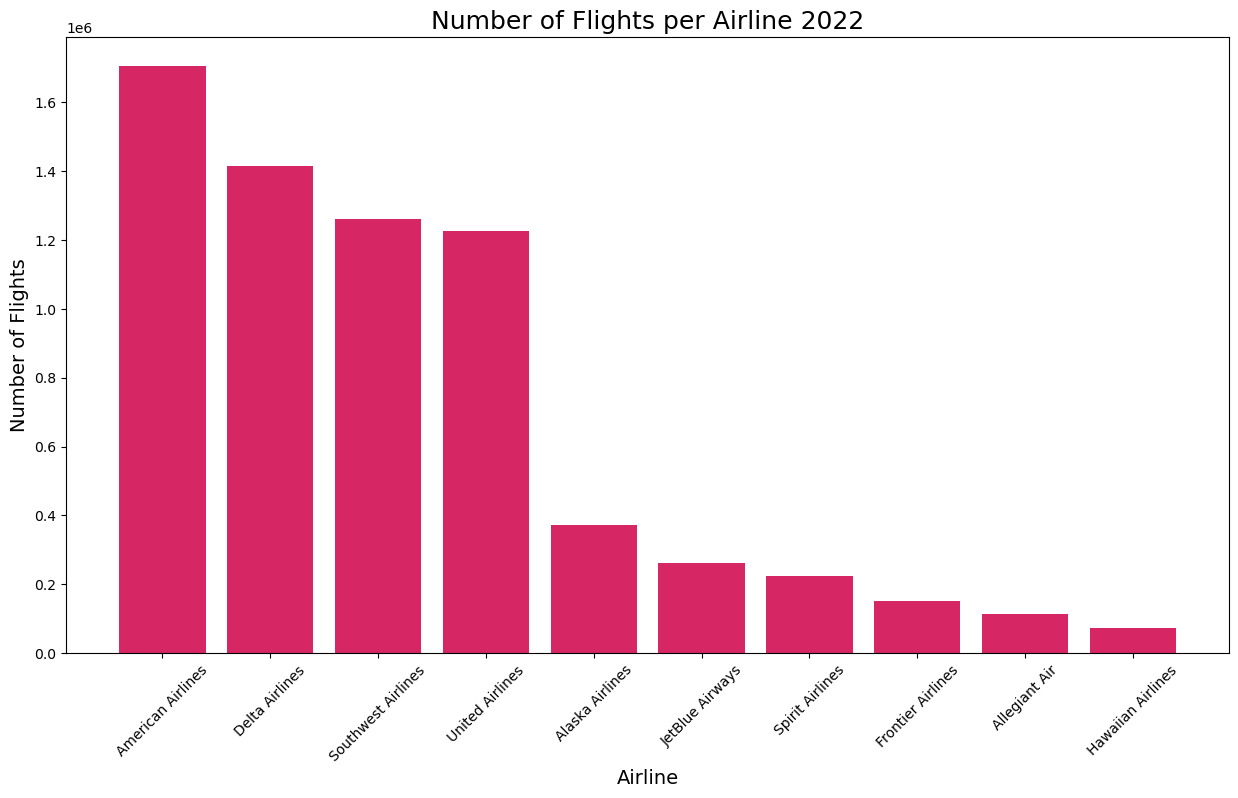

In [4]:
airline_counts = df['Airlines'].value_counts()

plt.figure(figsize=(15,8))
plt.bar(airline_counts.index, airline_counts.values, color="#d62764")
plt.title("Number of Flights per Airline 2022", fontsize=18)
plt.xlabel("Airline", fontsize=14)
plt.ylabel("Number of Flights", fontsize=14)
plt.xticks(rotation=45)  
plt.show()

In [5]:
# plt.Figure(figsize=(40,30))
# sns.scatterplot(x='Distance', y='AirTime', hue='Airlines', data=df)

C:\Users\rosea\AppData\Local\Temp\ipykernel_36220\2748228462.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ArrDelay', y='Route', data=top10_routes, palette=pink_colors)


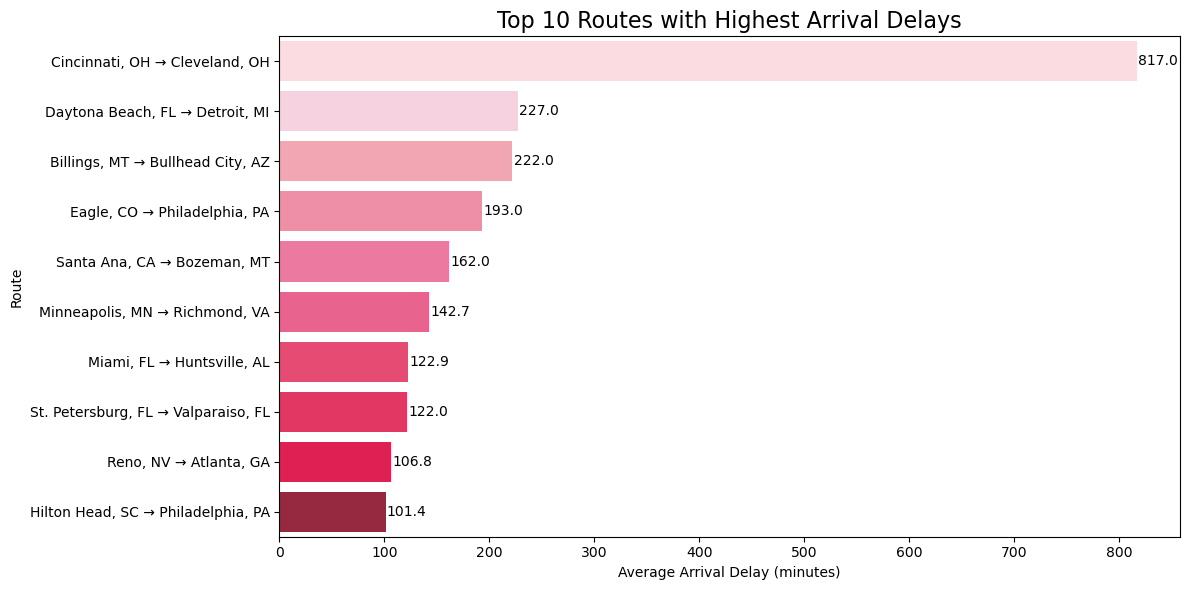

In [6]:
# نسخة مؤقتة للرسم
df_plot = df.copy()
df_plot['Route'] = df_plot['OriginCityName'] + " → " + df_plot['DestCityName']

# بقيت الكود للرسم زي ما عملتي
route_delay = df_plot.groupby('Route')['ArrDelay'].mean().sort_values(ascending=False)
top10_routes = route_delay.head(10).reset_index()
pink_colors = ["#FFD7DE", "#FCCCE0", "#FF99AA", "#FF7F9F", "#FF6699",
               "#FF4D88", "#FF3366", "#FF1A55", "#FF0044", "#A81636"]

# رسم Barplot
plt.figure(figsize=(12,6))
ax = sns.barplot(x='ArrDelay', y='Route', data=top10_routes, palette=pink_colors)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 1, p.get_y() + p.get_height()/2, f'{width:.1f}', ha='left', va='center', fontsize=10)
plt.xlabel("Average Arrival Delay (minutes)")
plt.ylabel("Route")
plt.title("Top 10 Routes with Highest Arrival Delays", fontsize=16)
plt.tight_layout()
plt.show()

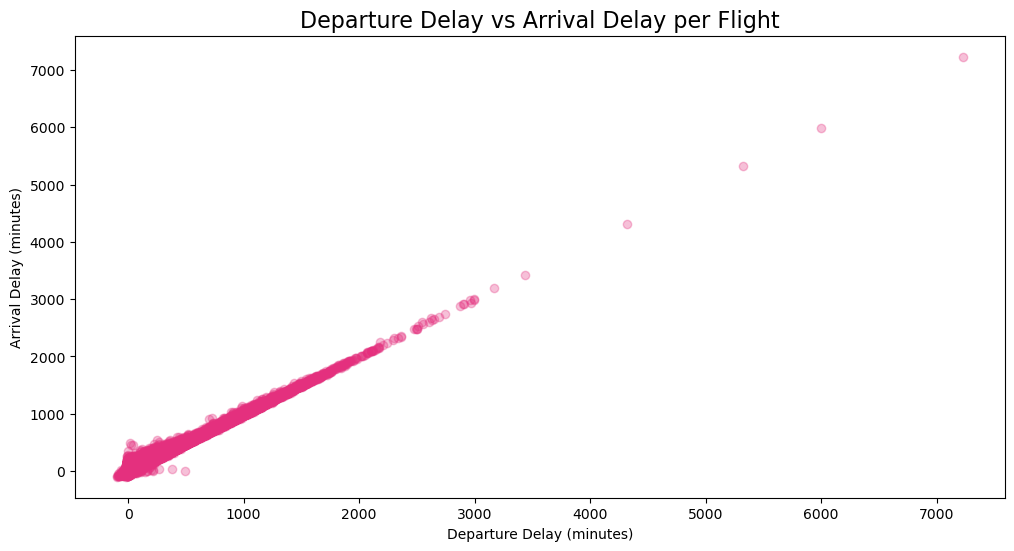

In [7]:
plt.figure(figsize=(12,6))
plt.scatter(df['DepDelay'], df['ArrDelay'], alpha=0.3, color="#e4307e")
plt.title("Departure Delay vs Arrival Delay per Flight", fontsize=16)
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Arrival Delay (minutes)")
plt.show()


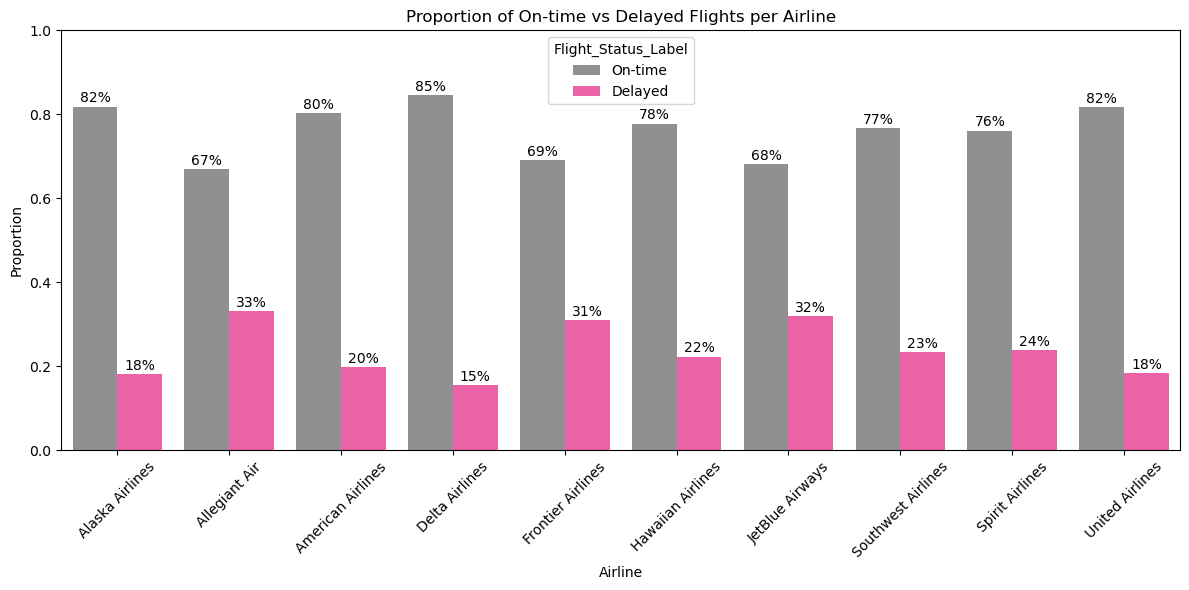

In [ ]:
# تحليل نسبي (Percentage Analysis) لكل شركة طيران:
#قد إيه رحلاتها On-time وقد إيه Delayed.
df_plot = df.copy()

# إنشاء Flight_Status_Label مؤقت
df_plot['Flight_Status_Label'] = df_plot['Flight_Status'].map({0:'On-time', 1:'Delayed'})

# حساب النسب لكل شركة طيران
df_percent = (
    df_plot
    .groupby('Airlines')['Flight_Status_Label']
    .value_counts(normalize=True)
    .rename('percent')
    .reset_index()
)

# ألوان
palette_colors = {'On-time':"#919090", 'Delayed':"#ff4da6"}

# رسم Barplot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x='Airlines',
    y='percent',
    hue='Flight_Status_Label',
    data=df_percent,
    palette=palette_colors
)

# إضافة النسب فوق الأعمدة
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(
            p.get_x() + p.get_width()/2.,
            height + 0.01,
            f'{height:.0%}',
            ha="center",
            fontsize=10
        )

plt.ylim(0,1)
plt.xticks(rotation=45)
plt.title("Proportion of On-time vs Delayed Flights per Airline")
plt.xlabel("Airline")
plt.ylabel("Proportion")
plt.tight_layout()
plt.show()


In [9]:
df['FlightDate'] = pd.to_datetime(df['FlightDate'], errors='coerce') 
df['Year'] = df['FlightDate'].dt.year

print(df[['FlightDate','Year']].head())
df.drop(columns=['FlightDate'],inplace=True)

  FlightDate  Year
0 2022-01-06  2022
1 2022-01-06  2022
2 2022-01-06  2022
3 2022-01-06  2022
4 2022-01-06  2022


In [10]:
df=df.drop(["DepDelay"],axis=1)

In [11]:
from sklearn.preprocessing import TargetEncoder
categorical_cols = ["Airlines", "OriginCityName", "DestCityName"]
all_encoders = {}
for col in categorical_cols:
    te = TargetEncoder()
    df[col] = te.fit_transform(df[[col]], df["Flight_Status"])
    all_encoders[col] = te  # نخزن الـ encoder لكل عمود في dictionary

pickle.dump(all_encoders, open("encoding.pkl", "wb"))


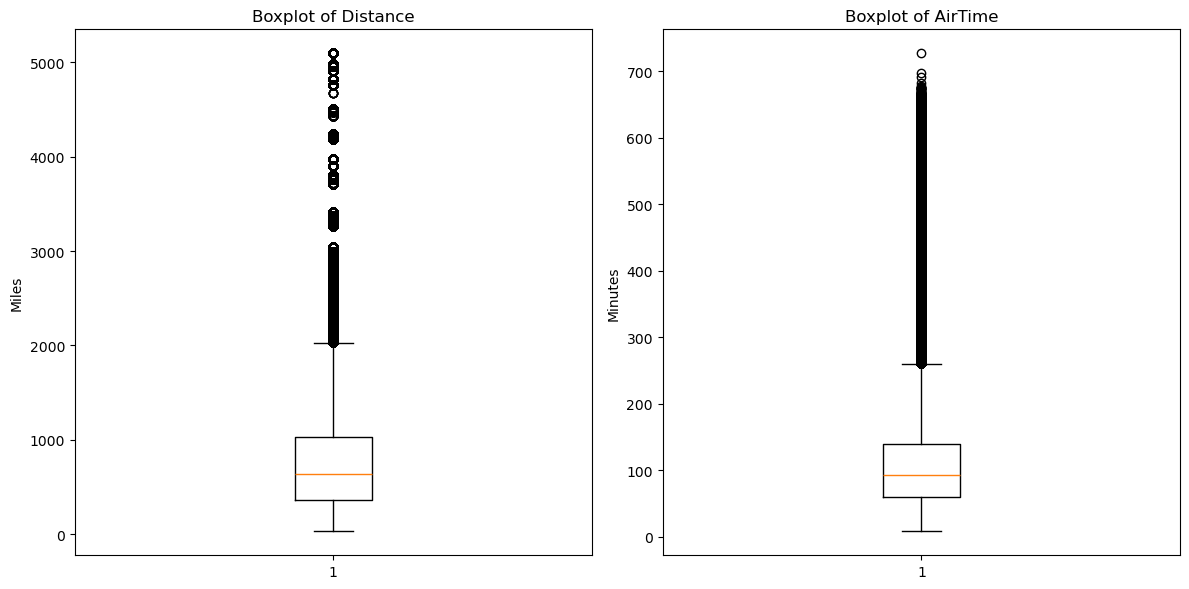

In [12]:

plt.figure(figsize=(12, 6))

# الرسم الأول: المسافة
plt.subplot(1, 2, 1) 
plt.boxplot(df["Distance"])
plt.title("Boxplot of Distance")
plt.ylabel("Miles")

plt.subplot(1, 2, 2)
plt.boxplot(df["AirTime"])
plt.title("Boxplot of AirTime")
plt.ylabel("Minutes")

plt.tight_layout() 
plt.show()

In [13]:
x=df.drop(["Flight_Status"],axis=1)
y=df["Flight_Status"]

In [14]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [15]:
from sklearn.preprocessing import PowerTransformer
import pickle

numeric_cols = ["AirTime","Distance"]

pt = PowerTransformer(method='yeo-johnson')
df[numeric_cols] = pt.fit_transform(df[numeric_cols])

# حفظ الـ scaler كامل في ملف واحد
pickle.dump(pt, open("scaling.pkl", "wb"))

print("✅ Scaling saved for all numeric columns!")


✅ Scaling saved for all numeric columns!


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score,make_scorer
XG = XGBClassifier(
learning_rate=0.01, max_depth=3, n_estimators=50,scale_pos_weight=4    #إننا بندّي وزن أكبر للكلاس الأقل عددًا عشان الموديل ما يتجاهلوش.
)

XG.fit(x_train, y_train)

y_pred_test = XG.predict(x_test)
print(f1_score(y_test, y_pred_test))

pickle.dump(XG,open("model.pkl",'wb'))


1.0


In [19]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# grid_search = GridSearchCV(
#     estimator=XG,
#     param_grid=param_grid,
#     scoring=make_scorer(f1_score),  
#     cv=5,  # cross-validation 5-fold
#     n_jobs=1,  # يستخدم كل المعالجات المتاحة لتسريع العملية
#     verbose=2
# )
# grid_search.fit(x_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)



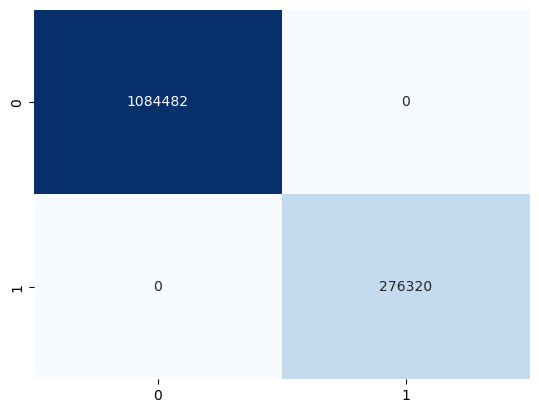

In [20]:
from sklearn.metrics import confusion_matrix ,classification_report

cm=confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.show()

In [21]:
print(classification_report(y_test,y_pred_test,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1084482
           1       1.00      1.00      1.00    276320

    accuracy                           1.00   1360802
   macro avg       1.00      1.00      1.00   1360802
weighted avg       1.00      1.00      1.00   1360802



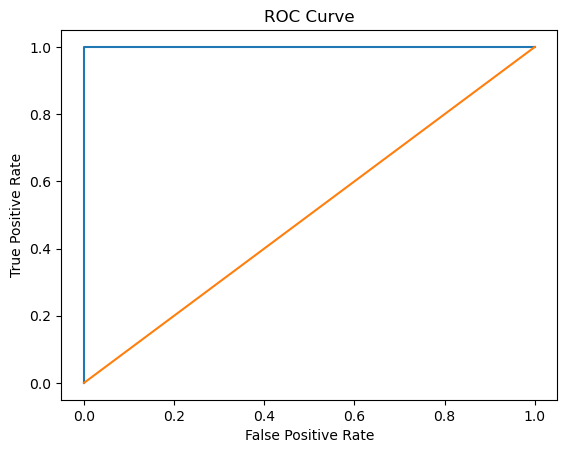

In [22]:
y_pred_proba = XG.predict_proba(x_test)[:,1]
from sklearn.metrics import roc_curve,precision_recall_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr,tpr)
plt.plot([0,1], [0,1])  # خط عشوائي
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

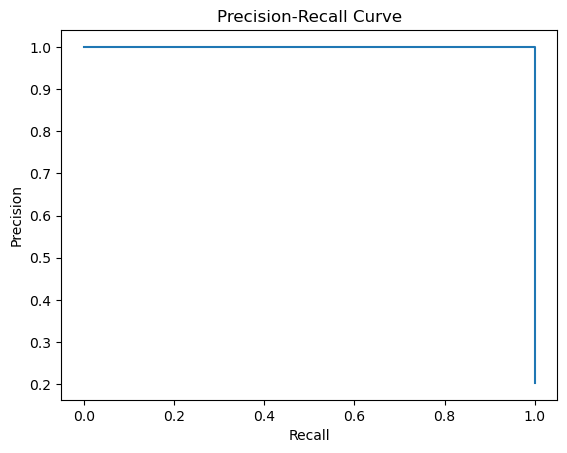

In [23]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()